In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
import re
import seaborn as sns
from pprint import pprint

In [2]:
# os.chdir(r"C:\Users\parzi\OneDrive - Tribhuvan University\Desktop\Major Project\CODE\BCS Code\BCS-ALL-Code\Crossword Solver")

In [3]:
glob.glob('./Second pass model outputs/*.txt')

['./Second pass model outputs\\ByT5 Console Output.txt',
 './Second pass model outputs\\byt5 multi iteration data.txt',
 './Second pass model outputs\\T5 Console Output.txt',
 './Second pass model outputs\\t5 full dateaset word segment.txt',
 './Second pass model outputs\\t5 multi iteration 70 percentage data trained on.txt',
 './Second pass model outputs\\t5 multi iteration data segmented answer model.txt',
 './Second pass model outputs\\t5 multi iteration data segmented answer model_2.txt',
 './Second pass model outputs\\t5 multi iteration data word segmented.txt',
 './Second pass model outputs\\t5 multi iteration data.txt',
 './Second pass model outputs\\t5 multi iteration wod segmented 2 epochs.txt',
 './Second pass model outputs\\t5 training output.txt',
 './Second pass model outputs\\t5_small on all dataset training.txt']

In [4]:
def extract_float(input_string):
    pattern = r"\d+\.\d+"
    matches = re.findall(pattern, input_string)
    float_numbers = [float(match) for match in matches]
    return float_numbers

In [44]:
def get_mean_data(F_NAME):
    # F_NAME = "byt5 multi iteration data.txt"
    with open(F_NAME, 'r') as f:
        lines = f.readlines()
    date_pattern = r"\b\d{2}/\d{2}/\d{4}\b"
    data_dict = {}
    new_date_math = False
    current_date = ''

    for line in lines:
        match = re.match(date_pattern, line) # to match the date pattern

        if match:
            current_date = line.strip()
            data_dict[current_date] = {}
            data_dict[current_date]['Letter II'] = []
            data_dict[current_date]['Word II'] = []

        if 'Before' in line:
            [lett_accu, word_accu] = extract_float(line)
            data_dict[current_date]['Before Letter Accuracy'] = lett_accu
            data_dict[current_date]['Before Word Accuracy'] = word_accu

        if 'iteration:' in line:
            lett_accu, word_accu = extract_float(line)
            data_dict[current_date]['Letter II'].append(lett_accu)
            data_dict[current_date]['Word II'].append(word_accu)
            
    max_length = 0
    for key, value in data_dict.items():
        if len(value['Letter II']) > max_length:
            max_length = len(value['Letter II'])
    
    # cause the maximum with the ByT5 is 5 so
#     max_length = 5
            
    # extending all the letter and word accuracy float values to the maxm length
    for key, value in data_dict.items():
        if len(value['Letter II']) < max_length:
            if len(value['Letter II']) == 0:
                last_lett_accu = value['Before Letter Accuracy']
                last_word_accu = value['Before Word Accuracy']
            else:
                last_lett_accu = value['Letter II'][-1]
                last_word_accu = value['Word II'][-1]
                
            for i in range(max_length - len(value['Letter II'])):
                data_dict[key]['Letter II'].append(last_lett_accu)
                data_dict[key]['Word II'].append(last_word_accu)

    all_letter_accu_list = []
    all_word_accu_list = []

    for key, value in data_dict.items():
        letter_accu_list = value['Letter II'].copy()
        letter_accu_list.insert(0, value['Before Letter Accuracy'])
        all_letter_accu_list.append(letter_accu_list)

        word_accu_list = value['Word II'].copy()
        word_accu_list.insert(0, value['Before Word Accuracy'])
        all_word_accu_list.append(word_accu_list)
    
    all_letter_accu = np.array(all_letter_accu_list)
    all_word_accu = np.array(all_word_accu_list)
    avg_letter_accu = np.mean(all_letter_accu, axis = 0)
    avg_word_accu = np.mean(all_word_accu, axis = 0)
    
    return avg_letter_accu, avg_word_accu, data_dict

#### T5_small trained on full dataset with Word Segmented vs ByT5_small Model

In [47]:
byt5_letter_list, byt5_word_list, _ = get_mean_data("./Second pass model outputs/byt5 multi iteration data.txt")
t5_letter_list, t5_word_list, _ = get_mean_data("./Second pass model outputs/t5 multi iteration wod segmented 2 epochs.txt")
t5_letter_list_1, t5_word_list_1, _ = get_mean_data("./Second pass model outputs/t5 multi iteration data.txt")

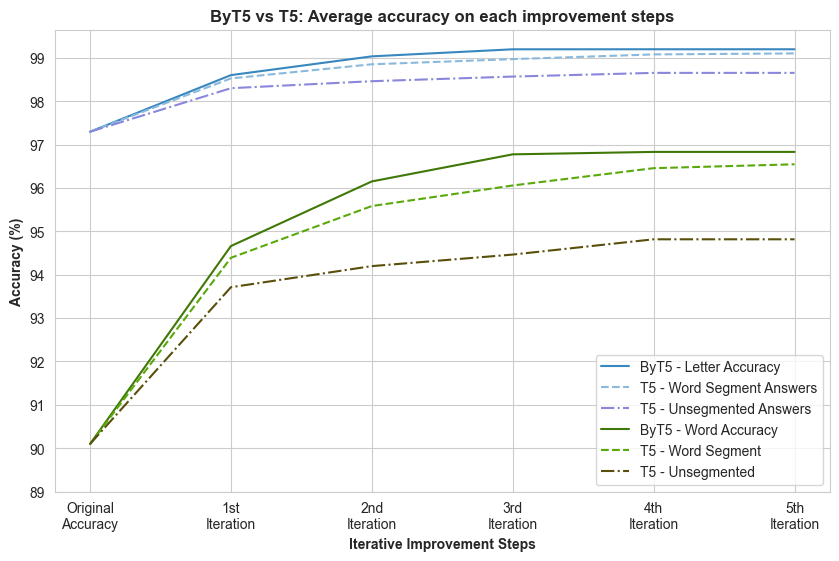

In [135]:
# BYT5 graphical analysis on the iterative improvement steps
sns.set_style('whitegrid')
plt.figure(figsize = (10, 6))

plt.plot(byt5_letter_list, label = 'ByT5 - Letter Accuracy', color = (56/255, 135/255, 190/255))
plt.plot(t5_letter_list[:6], label = 'T5 - Word Segment Answers', linestyle = '--', color = (137/255, 185/255, 220/255))
plt.plot(t5_letter_list_1, label = 'T5 - Unsegmented Answers', linestyle = '-.', color = (137/255, 135/255, 220/255))


plt.plot(byt5_word_list, label = 'ByT5 - Word Accuracy', color = (64/255, 120/255, 7/255))
plt.plot(t5_word_list[:6], label = 'T5 - Word Segment', linestyle = '--', color = (89/255, 169/255, 10/255))
plt.plot(t5_word_list_1, label = 'T5 - Unsegmented', linestyle = '-.', color = (89/255, 79/255, 10/255))
plt.legend(loc = 'best')

custom_xticks = ['Original\nAccuracy', '1st\nIteration', '2nd\nIteration', '3rd\nIteration', '4th\nIteration', '5th\nIteration']
plt.xticks(range(len(custom_xticks)), custom_xticks)
plt.yticks(np.arange(89, 100, 1))
plt.xlabel("Iterative Improvement Steps", font = {'weight':'bold'})
plt.ylabel("Accuracy (%)", font = {'weight':'bold'})
plt.title("ByT5 vs T5: Average accuracy on each improvement steps", font = {'weight': 'bold', 'size': 12})
plt.savefig('./iterative stand.png', dpi = 360, bbox_inches = 'tight')
plt.show()

#### Date-by-Date comparison between both models

In [49]:
_, _, byt5_data = get_mean_data("./Second pass model outputs/byt5 multi iteration data.txt")
_, _, t5_data = get_mean_data("./Second pass model outputs/t5 multi iteration wod segmented 2 epochs.txt")

In [92]:
def get_report_df(data_dict):
    individual_accs = []
    for key, value in data_dict.items():
        b_lett_acc, b_word_acc = value['Before Letter Accuracy'], value['Before Word Accuracy']
        if b_lett_acc != 100.0:
            max_lett_acc = max(value['Letter II'])
            max_word_acc = value['Word II'][value['Letter II'].index(max_lett_acc)]
            individual_accs.append([key, b_lett_acc, b_word_acc, max_lett_acc, max_word_acc])
    report_df = pd.DataFrame(individual_accs, columns = ['Date', 'Before Letter Accuracy', 'Before Word Accuracy', 'After Letter Accuracy', 'After Word Accuracy'])
    return report_df

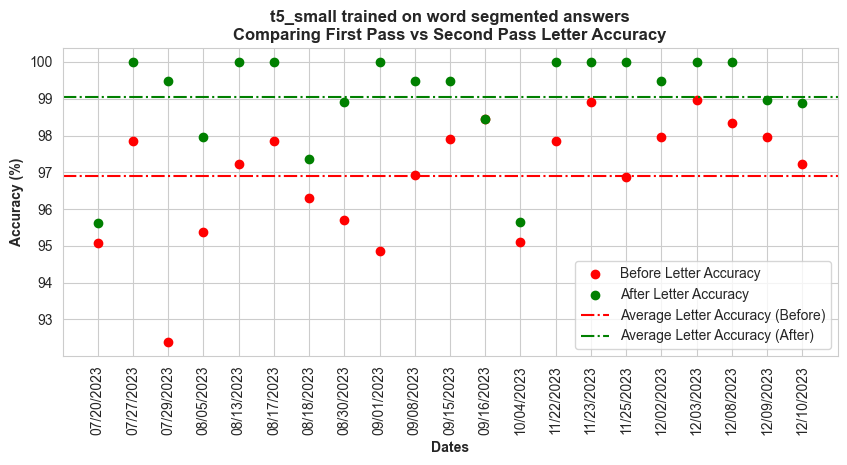

In [93]:
t5_report = get_report_df(t5_data)

before_avg_lett_acc = t5_report['Before Letter Accuracy'].mean()
after_avg_lett_acc = t5_report['After Letter Accuracy'].mean()

plt.figure(figsize = (10, 4))
plt.scatter(report_df['Date'], t5_report['Before Letter Accuracy'], color = 'r', label = 'Before Letter Accuracy')
plt.scatter(report_df['Date'], t5_report['After Letter Accuracy'], color = 'g', label = 'After Letter Accuracy')
plt.axhline(y = before_avg_lett_acc, color='r', linestyle='-.', label='Average Letter Accuracy (Before)')
plt.axhline(y = after_avg_lett_acc, color='g', linestyle='-.', label='Average Letter Accuracy (After)')

plt.xticks(rotation = 90)
plt.xlabel("Dates", fontsize = 10, fontweight = 'bold')
plt.ylabel("Accuracy (%)", fontsize = 10, fontweight = 'bold')
plt.title("t5_small trained on word segmented answers\nComparing First Pass vs Second Pass Letter Accuracy", fontsize = 12, fontweight = 'bold')
plt.legend(loc = 'best')
plt.show()

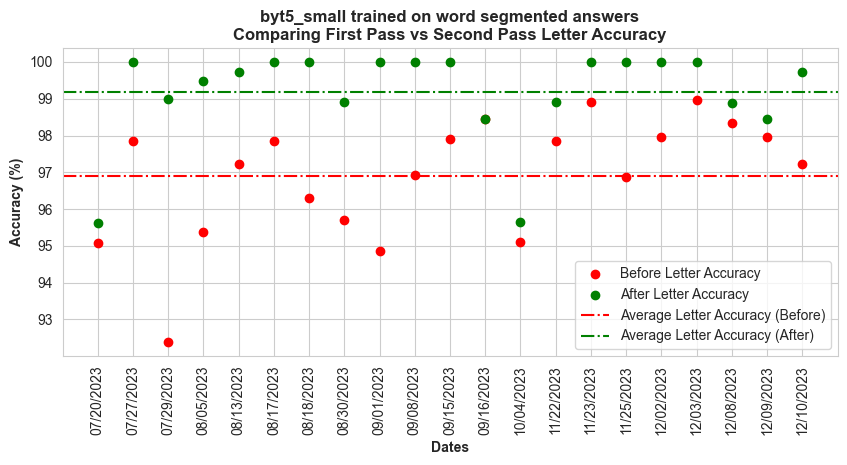

In [94]:
byt5_report = get_report_df(byt5_data)

before_avg_lett_acc = byt5_report['Before Letter Accuracy'].mean()
after_avg_lett_acc = byt5_report['After Letter Accuracy'].mean()

plt.figure(figsize = (10, 4))
plt.scatter(report_df['Date'], byt5_report['Before Letter Accuracy'], color = 'r', label = 'Before Letter Accuracy')
plt.scatter(report_df['Date'], byt5_report['After Letter Accuracy'], color = 'g', label = 'After Letter Accuracy')
plt.axhline(y = before_avg_lett_acc, color='r', linestyle='-.', label='Average Letter Accuracy (Before)')
plt.axhline(y = after_avg_lett_acc, color='g', linestyle='-.', label='Average Letter Accuracy (After)')

plt.xticks(rotation = 90)
plt.xlabel("Dates", fontsize = 10, fontweight = 'bold')
plt.ylabel("Accuracy (%)", fontsize = 10, fontweight = 'bold')
plt.title("byt5_small trained on word segmented answers\nComparing First Pass vs Second Pass Letter Accuracy", fontsize = 12, fontweight = 'bold')
plt.legend(loc = 'best')
plt.show()

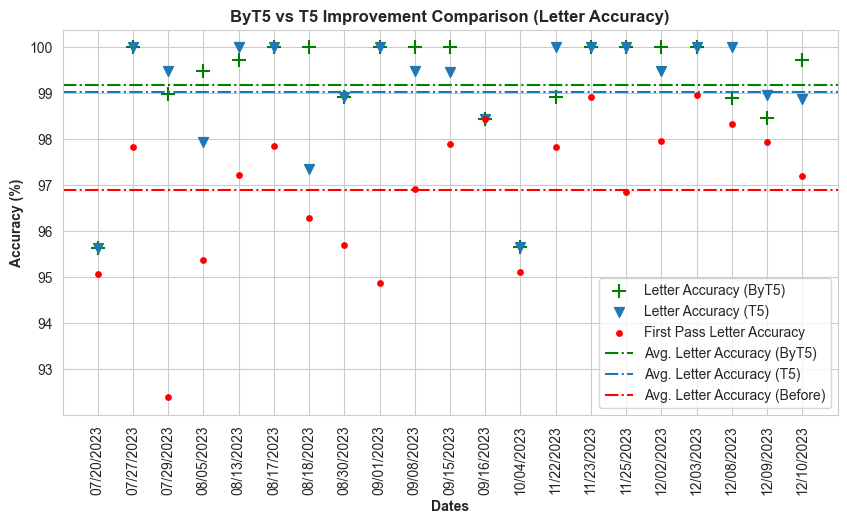

In [130]:
byt5_report = get_report_df(byt5_data)

assert len(byt5_report) == len(t5_report)

byt5_b_let_acc = byt5_report['Before Letter Accuracy'].mean()
byt5_a_let_acc = byt5_report['After Letter Accuracy'].mean()

t5_b_let_acc = t5_report['Before Letter Accuracy'].mean()
t5_a_let_acc = t5_report['After Letter Accuracy'].mean()

plt.figure(figsize = (10, 5))

plt.scatter(byt5_report['Date'], byt5_report['After Letter Accuracy'], marker = '+', s = 100, color = 'g', label = 'Letter Accuracy (ByT5)')
plt.scatter(t5_report['Date'], t5_report['After Letter Accuracy'], marker = 'v', s = 50, label = 'Letter Accuracy (T5)')
plt.scatter(byt5_report['Date'], byt5_report['Before Letter Accuracy'], marker = 'o', s = 15, color = 'r', label = 'First Pass Letter Accuracy')

plt.axhline(y = byt5_a_let_acc, color='g', linestyle='-.', label='Avg. Letter Accuracy (ByT5)')
plt.axhline(y = t5_a_let_acc,  linestyle='-.', label='Avg. Letter Accuracy (T5)')
plt.axhline(y = byt5_b_let_acc, color='r', linestyle='-.', label='Avg. Letter Accuracy (Before)')

plt.xticks(rotation = 90)
plt.xlabel("Dates", fontsize = 10, fontweight = 'bold')
plt.ylabel("Accuracy (%)", fontsize = 10, fontweight = 'bold')
plt.title("ByT5 vs T5 Improvement Comparison (Letter Accuracy)", fontsize = 12, fontweight = 'bold')
plt.legend(loc = 'best')

plt.savefig("byt5 vs t5 improvement comparison on letter accuracy.png", dpi = 360, bbox_inches = 'tight')
plt.show()

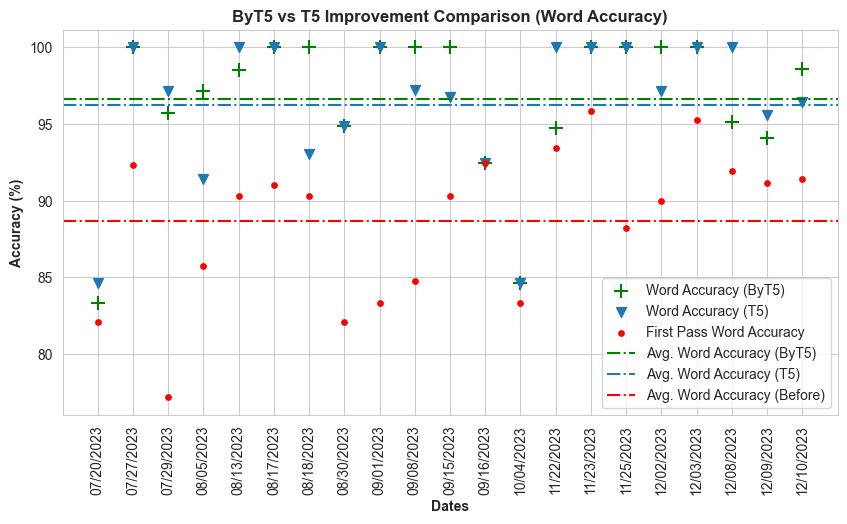

In [131]:
byt5_b_let_acc = byt5_report['Before Word Accuracy'].mean()
byt5_a_let_acc = byt5_report['After Word Accuracy'].mean()

t5_b_let_acc = t5_report['Before Word Accuracy'].mean()
t5_a_let_acc = t5_report['After Word Accuracy'].mean()

plt.figure(figsize = (10, 5))

plt.scatter(byt5_report['Date'], byt5_report['After Word Accuracy'], marker = '+', s = 100, color = 'g', label = 'Word Accuracy (ByT5)')
plt.scatter(t5_report['Date'], t5_report['After Word Accuracy'], marker = 'v', s = 50, label = 'Word Accuracy (T5)')
plt.scatter(byt5_report['Date'], byt5_report['Before Word Accuracy'], marker = 'o', s = 15, color = 'r', label = 'First Pass Word Accuracy')

plt.axhline(y = byt5_a_let_acc, color='g', linestyle='-.', label='Avg. Word Accuracy (ByT5)')
plt.axhline(y = t5_a_let_acc,  linestyle='-.', label='Avg. Word Accuracy (T5)')
plt.axhline(y = byt5_b_let_acc, color='r', linestyle='-.', label='Avg. Word Accuracy (Before)')

plt.xticks(rotation = 90)
plt.xlabel("Dates", fontsize = 10, fontweight = 'bold')
plt.ylabel("Accuracy (%)", fontsize = 10, fontweight = 'bold')
plt.title("ByT5 vs T5 Improvement Comparison (Word Accuracy)", fontsize = 12, fontweight = 'bold')
plt.legend(loc = 'best')

plt.savefig("byt5 vs t5 improvement comparison on Word accuracy.png", dpi = 360, bbox_inches = 'tight')
plt.show()

#### T5_small trained on 3M dataset for 2 epoch vs ByT5_small Model

In [ ]:
byt5_letter_list, byt5_word_list = get_mean_data("./Result and Analysis Section/Second pass model outputs/byt5 multi iteration data.txt")
t5_letter_list, t5_word_list = get_mean_data("./Result and Analysis Section/Second pass model outputs/t5 multi iteration data word segmented.txt")
t5_letter_list_1, t5_word_list_1 = get_mean_data("./Result and Analysis Section/Second pass model outputs/t5 multi iteration data.txt")

In [ ]:
# BYT5 graphical analysis on the iterative improvement steps
sns.set_style('whitegrid')
plt.figure(figsize = (8, 4))

plt.plot(byt5_letter_list, label = 'ByT5 - Letter', color = (56/255, 135/255, 190/255))
plt.plot(t5_letter_list, label = 'T5 - Word Segment Answers', linestyle = '-.', color = (137/255, 185/255, 220/255))
plt.plot(t5_letter_list_1, label = 'T5 - Unsegmented Answers', linestyle = '-.', color = (137/255, 135/255, 220/255))


plt.plot(byt5_word_list, label = 'ByT5 - Word', color = (64/255, 120/255, 7/255))
plt.plot(t5_word_list, label = 'T5 - Word Segment', linestyle = '-.', color = (89/255, 169/255, 10/255))
plt.plot(t5_word_list_1, label = 'T5 - Unsegmented', linestyle = '-.', color = (89/255, 79/255, 10/255))
plt.legend(loc = 'best')

custom_xticks = ['Original\nAccuracy', '1st\nIteration', '2nd\nIteration', '3rd\nIteration', '4th\nIteration', '5th\nIteration']
plt.xticks(range(len(custom_xticks)), custom_xticks)
plt.yticks(np.arange(89, 100, 1))
plt.xlabel("Iterative Improvement Steps", font = {'weight':'bold'})
plt.ylabel("Accuracy (%)", font = {'weight':'bold'})
# plt.title("Byt5 as Second Pass Model")
plt.show()

#### T5_small trained one full epoch with 64 batch size, with segmented answers

In [ ]:
byt5_letter_list, byt5_word_list = get_mean_data("./Second pass model outputs/byt5 multi iteration data.txt")
t5_letter_list, t5_word_list = get_mean_data("./Second pass model outputs/t5 multi iteration data.txt")

In [ ]:
# BYT5 graphical analysis on the iterative improvement steps
sns.set_style('whitegrid')
plt.figure(figsize = (8, 4))

plt.plot(byt5_letter_list, label = 'Average Letter Accuracy')
plt.plot(byt5_word_list, label = 'Average Word Accuracy')
plt.legend(loc = 'best')

custom_xticks = ['Original\nAccuracy', '1st\nIteration', '2nd\nIteration', '3rd\nIteration', '4th\nIteration', '5th\nIteration']
plt.xticks(range(len(custom_xticks)), custom_xticks)
plt.yticks(np.arange(89, 100, 1))

plt.title("Byt5 as Second Pass Model")
plt.show()

In [ ]:
# BYT5 graphical analysis on the iterative improvement steps
sns.set_style('whitegrid')
plt.figure(figsize = (8, 4))

plt.plot(t5_letter_list, label = 'Average Letter Accuracy')
plt.plot(t5_word_list, label = 'Average Word Accuracy')
plt.legend(loc = 'best')

custom_xticks = ['Original\nAccuracy', '1st\nIteration', '2nd\nIteration', '3rd\nIteration', '4th\nIteration', '5th\nIteration']
plt.xticks(range(len(custom_xticks)), custom_xticks)
plt.yticks(np.arange(89, 100, 1))

plt.title("T5 as Second Pass Model")
plt.show()

#### Comparison between ByT5 and T5

In [ ]:
# BYT5 graphical analysis on the iterative improvement steps
sns.set_style('whitegrid')
plt.figure(figsize = (8, 4))

plt.plot(byt5_letter_list, label = 'ByT5 - Average letter accuracy', color = (56/255, 135/255, 190/255))
plt.plot(t5_letter_list, label = 'T5 - Average letter accuracy', linestyle = '-.', color = (137/255, 185/255, 220/255))

plt.plot(byt5_word_list, label = 'ByT5 - Average word accuracy', color = (64/255, 120/255, 7/255))
plt.plot(t5_word_list, label = 'T5 - Average word accuracy', linestyle = '-.', color = (89/255, 169/255, 10/255))
plt.legend(loc = 'best')

custom_xticks = ['Original\nAccuracy', '1st\nIteration', '2nd\nIteration', '3rd\nIteration', '4th\nIteration', '5th\nIteration']
plt.xticks(range(len(custom_xticks)), custom_xticks)
plt.yticks(np.arange(89, 100, 1))
plt.xlabel("Iterative Improvement Steps", font = {'weight':'bold'})
plt.ylabel("Accuracy (%)", font = {'weight':'bold'})
# plt.title("Byt5 as Second Pass Model")
plt.show()

#### T5_small trained with segmented answer and tokenizer set to 32 sequence length for both input (clue) & label (answer)

In [ ]:
t5_letter_list_1, t5_word_list_1 = get_mean_data("./Second pass model outputs/t5 multi iteration data segmented answer model.txt")

# BYT5 graphical analysis on the iterative improvement steps
sns.set_style('whitegrid')
plt.figure(figsize = (8, 4))

plt.plot(t5_letter_list_1, label = 'Average Letter Accuracy')
plt.plot(t5_word_list_1, label = 'Average Word Accuracy')
plt.legend(loc = 'best')

custom_xticks = ['Original\nAccuracy', '1st\nIteration', '2nd\nIteration', '3rd\nIteration']
for i in range(4, len(t5_letter_list_1)):
    custom_xticks.append(f"{i}th\nIteration")
    
plt.xticks(range(len(custom_xticks)), custom_xticks)
plt.yticks(np.arange(89, 100, 1))

plt.title("T5 as Second Pass Model")
plt.show()

In [ ]:
t5_letter_list_1, t5_word_list_1 = get_mean_data("./Second pass model outputs/t5 multi iteration data segmented answer model_2.txt")

# BYT5 graphical analysis on the iterative improvement steps
sns.set_style('whitegrid')
plt.figure(figsize = (8, 4))

plt.plot(t5_letter_list_1, label = 'Average Letter Accuracy')
plt.plot(t5_word_list_1, label = 'Average Word Accuracy')
plt.legend(loc = 'best')

custom_xticks = ['Original\nAccuracy', '1st\nIteration', '2nd\nIteration', '3rd\nIteration']
for i in range(4, len(t5_letter_list_1)):
    custom_xticks.append(f"{i}th\nIteration")
    
plt.xticks(range(len(custom_xticks)), custom_xticks)
plt.yticks(np.arange(89, 100, 1))

plt.title("T5 as Second Pass Model")
plt.show()

#### Analyzing all the T5_small model iterative ability

In [ ]:
t5_letter_list_0, t5_word_list_0 = get_mean_data("./Second pass model outputs/t5 multi iteration data.txt")
t5_letter_list_1, t5_word_list_1 = get_mean_data("./Second pass model outputs/t5 multi iteration data segmented answer model.txt")
t5_letter_list_2, t5_word_list_2 = get_mean_data("./Second pass model outputs/t5 multi iteration data segmented answer model_2.txt")

# BYT5 graphical analysis on the iterative improvement steps
sns.set_style('whitegrid')
plt.figure(figsize = (8, 4))

plt.plot(t5_letter_list_0, label = 'T5 - Unsegmented trained 32-bit')
# plt.plot(t5_letter_list_1, label = 'T5 - Average letter accuracy', linestyle = '-.')
plt.plot(t5_letter_list_2, label = 'T5 - Segmented trained tokenized set', linestyle = '--')

plt.plot(t5_word_list_0, label = 'ByT5 - Average word accuracy')
# plt.plot(t5_word_list_1, label = 'ByT5 - Average word accuracy', linestyle = '-.')
plt.plot(t5_word_list_2, label = 'ByT5 - Average word accuracy', linestyle = '--')
plt.legend(loc = 'best')

custom_xticks = ['Original\nAccuracy', '1st\nIteration', '2nd\nIteration', '3rd\nIteration', '4th\nIteration', '5th\nIteration']
plt.xticks(range(len(custom_xticks)), custom_xticks)
plt.yticks(np.arange(89, 100, 1))
plt.xlabel("Iterative Improvement Steps", font = {'weight':'bold'})
plt.ylabel("Accuracy (%)", font = {'weight':'bold'})
# plt.title("Byt5 as Second Pass Model")
plt.show()

<b>In every test upto this point, t5_small performed bad in compared to the byt5_small fine-tuned from the BCS. So, a possible improved training strategy could be to train the t5_small again without using sequence length restriction. 